<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/2-text-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [13]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [15]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
specfic_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip'
#!ls "$root_dir"
root_dir = "/content/data"
data_dir = root_dir + "/lm-data/names"


!unzip '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip' -d "$root_dir"

unzip:  cannot find or open /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip, /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip.zip or /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip.ZIP.


python(65131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [16]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


print(n_letters)
 
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Malmöääe'))

57
Malmoaae


In [17]:
def findFiles(path): return glob.glob(path)

print(findFiles(data_dir + '/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + '/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
# print(category_lines)

[]
0


In [18]:
print(category_lines['Greek'][:5])
print(category_lines['Spanish'])

KeyError: 'Greek'

### Make everything into one-hot vector ###

For it to be used (transform into a tensor). Here we are doing a character-based one-hot vector

In [47]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(letterToTensor('o'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [48]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#       print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#       print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [50]:
x = letterToTensor('A')
print(x.shape)
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()
print(hidden.shape)

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

torch.Size([1, 57])
torch.Size([1, 128])
tensor([15])
tensor([[15, 16,  2]])


In [51]:
x = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], next_hidden)
output, next_hidden = rnn(x[2], next_hidden)
output, next_hidden = rnn(x[3], next_hidden)
output, next_hidden = rnn(x[4], next_hidden)
output, next_hidden = rnn(x[5], next_hidden)
output, next_hidden = rnn(x[6], next_hidden)
print(output.argmax(-1))

tensor([1])


## Preparing for training! ##

In [8]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

NameError: name 'output' is not defined

### Quick way to get training example (Src = Name, Trg = Language) ###

In [9]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

NameError: name 'all_categories' is not defined

In [55]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [57]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [58]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 8s) 2.3201 Kwei / Korean ✗ (Chinese)
10000 100% (0m 17s) 5.2702 Lis / Korean ✗ (Polish)


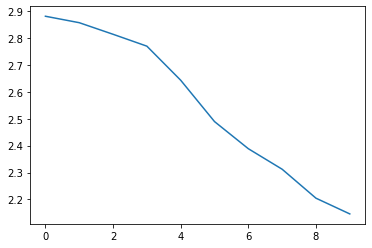

In [59]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

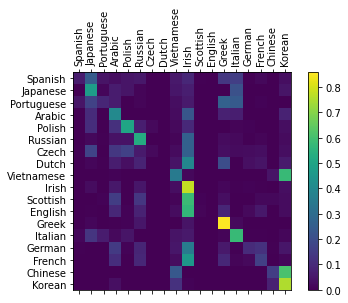

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [61]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.66) Russian
(-1.90) Polish
(-2.03) Irish

> Jackson
(-1.56) Irish
(-1.81) Scottish
(-1.91) Russian

> Satoshi
(-1.64) Italian
(-1.97) Polish
(-1.98) Japanese

> Alberto
(-1.68) Italian
(-2.04) Portuguese
(-2.10) Spanish


### So now lets shift to using the RNN Module from Pytorch ###

In [62]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

category = Irish / line = O'Gorman
category = Spanish / line = De leon
category = Vietnamese / line = Do
category = Portuguese / line = Cardozo
category = Polish / line = Koziol
category = Chinese / line = Chaim
category = Spanish / line = Oriol
category = Russian / line = Jadryshnikov
category = Czech / line = Ponec
category = Scottish / line = Hamilton


In [63]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [64]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [65]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.9949 Bran / Chinese ✗ (Irish)
10000 10% (0m 13s) 1.1129 Mosconi / Italian ✓
15000 15% (0m 19s) 1.5127 Truong / Korean ✗ (Vietnamese)
20000 20% (0m 26s) 1.1294 Ho / Vietnamese ✓
25000 25% (0m 33s) 3.9603 Wornhor / Scottish ✗ (German)
30000 30% (0m 40s) 1.2015 Kim / Korean ✓
35000 35% (0m 46s) 2.4278 Amato / Japanese ✗ (Italian)
40000 40% (0m 53s) 1.4174 Shaw / Korean ✗ (Chinese)
45000 45% (0m 59s) 0.0204 Shiroyama / Japanese ✓
50000 50% (1m 6s) 0.0722 Nakahara / Japanese ✓
55000 55% (1m 12s) 3.6488 Boutros / Portuguese ✗ (Arabic)
60000 60% (1m 19s) 0.9673 Peatain / French ✗ (Irish)
65000 65% (1m 26s) 0.9108 Alldridge / English ✓
70000 70% (1m 33s) 3.0558 Rheem / Chinese ✗ (Korean)
75000 75% (1m 39s) 0.2855 Pokhlebkin / Russian ✓
80000 80% (1m 46s) 0.2756 Nguyen / Vietnamese ✓
85000 85% (1m 53s) 0.1464 Kalakos / Greek ✓
90000 90% (2m 0s) 0.5290 Fung / Chinese ✓
95000 95% (2m 6s) 0.3938 Dubhan / Irish ✓
100000 100% (2m 13s) 0.3336 Houttum / Dutch ✓


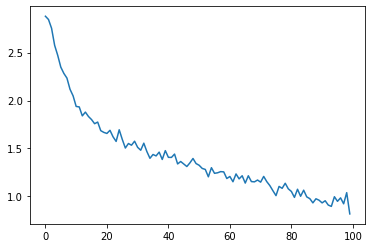

In [66]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [67]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [68]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-0.39) Russian
(-2.20) Irish
(-2.34) Czech

> Jackson
(-0.50) Scottish
(-1.83) English
(-2.30) Dutch

> Satoshi
(-0.12) Japanese
(-2.75) Arabic
(-3.28) Polish

> Alberto
(-0.97) Portuguese
(-1.17) Spanish
(-1.43) Italian


## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified

Assignment-Lab03-part03

My plan is to implement, I will give genre, and my program will produce a title of game.

So, I have to train the model sequence of letters and category like genre.

Input: A game genre (like "Action", "Puzzle", "RPG")
Output: A game title (like "Halo", "Tetris", "Final Fantasy")

In [114]:
import unicodedata
import string
import pandas as pd
from collections import defaultdict

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

all_genre = []
all_title = defaultdict(list) # [genre] = title mapping


data = pd.read_csv('vgsales.csv')
print(data.columns)

data_title = data['Name']
data_genre = data['Genre']
data_publisher = data['Publisher']

# print(data_title.shape)
# print(data_genre.shape)
# print(data_publisher.shape)

all_genre =  list(set(data_genre))
n_categories = len(all_genre)

print(all_genre)

for _, row in data.iterrows():
    name = row['Name']
    genre = row['Genre']

    if pd.notnull(name) and pd.notnull(genre):
        name_ = unicodeToAscii(str(name).strip())
        if name_:
            all_title[genre].append(name_)
        
print(all_title['Simulation'][:5]) 

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')
['Adventure', 'Misc', 'Strategy', 'Sports', 'Puzzle', 'Platform', 'Shooter', 'Action', 'Fighting', 'Racing', 'Simulation', 'Role-Playing']
['Nintendogs', 'Animal Crossing Wild World', 'Animal Crossing New Leaf', 'The Sims ', 'Cooking Mama']


In [162]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_genre)
    line = randomChoice(all_title[category])
    # print(f"line and category {line} {category}")
    if line:
        return category, line

# print(randomTrainingPair())

# One-hot vector for category
def categoryTensor(category):
    li = all_genre.index(category)
    # print(li)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    # print(tensor.shape)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# print(inputTensor("and"))

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


# print(targetTensor("abc"))

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

a, b, c = randomTrainingExample()
print(a.shape, b.shape, c.shape)
print(a, b, c)



torch.Size([1, 12]) torch.Size([25, 1, 59]) torch.Size([25])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]) tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]]) tensor([11,  0, 25, 27, 11, 20,  4, 52, 28,  0, 11,  0, 12,  8, 19, 24, 52, 45,
        17,  8,  6,  6,  4, 17, 58])


In [177]:
import torch
import torch.nn as nn

class RNN_Own(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Own, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size + n_categories, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        seq_len, batch_size, _ = input.size()
    
        # (batch_size, seq_len, n_categories)
        category_expanded = category.unsqueeze(1).expand(batch_size, seq_len, -1)
        
        # print(f"category_expanded.shape",category_expanded.shape)
        # print(f"input.shape", input.shape)
        input = input.permute(1, 0, 2)
    
        # concat on the last dim
        rnn_input = torch.cat((category_expanded, input), dim=2)  # (batch_size, seq_len, input_size + n_categories)
        
        # print(f"rnn_input.shape", rnn_input.shape)
    
        output, hidden = self.rnn(rnn_input, hidden)  # hidden: (num_layers, batch_size, hidden_size)
    
        output = output.contiguous().view(-1, self.hidden_size)  # (batch_size * seq_len, hidden_size)
        output = self.fc(output)  # (batch_size * seq_len, output_size)
        output = self.lsoftmax(output)
    
        return output, hidden


    def initHidden(self, batch_size= 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [195]:
rnn = RNN_Own(n_letters, 128, n_letters)
import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

def train(category_tensor, input_tensor, target_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    output, hidden = rnn(category_tensor, input_tensor, hidden)
    
    # print(f"target tensor fixed ", target_tensor[-2])
    # print(f"target tensor", target_tensor.shape)
    # print(f"output tensor", output.shape)
    
    # print(output)
    # print(target_tensor)
    
    loss = criterion(output, target_tensor)

    loss.backward()
    optimizer.step()

    return output, loss.item()


In [196]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [198]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 7s (5000 5%) 2.3808
0m 13s (10000 10%) 2.6885
0m 20s (15000 15%) 2.3720
0m 26s (20000 20%) 1.8227
0m 33s (25000 25%) 3.0103
0m 39s (30000 30%) 2.4906
0m 46s (35000 35%) 2.2777
0m 52s (40000 40%) 1.4805
0m 59s (45000 45%) 2.3585
1m 5s (50000 50%) 2.5146
1m 12s (55000 55%) 1.8177
1m 18s (60000 60%) 1.3019
1m 24s (65000 65%) 1.2586
1m 31s (70000 70%) 1.4834
1m 37s (75000 75%) 1.1098
1m 44s (80000 80%) 1.7895
1m 50s (85000 85%) 1.5563
1m 57s (90000 90%) 1.4782
2m 3s (95000 95%) 1.4232
2m 10s (100000 100%) 1.4831


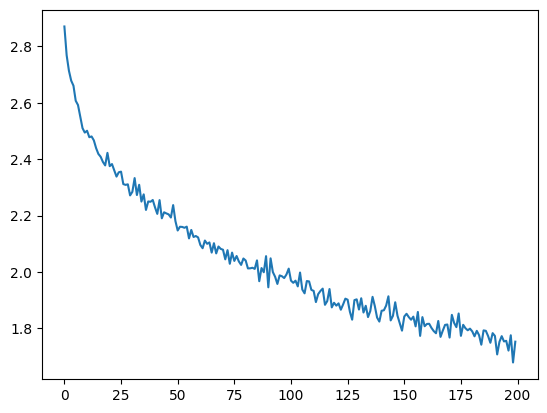

In [199]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [211]:
max_length = 100

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        
        hidden = rnn.initHidden()
        output_name = start_letter
        
        # print(category_tensor.shape)
        # print(input.shape)
        # print(hidden.shape)
        # print(output_name)

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input, hidden)
            #print(output.shape)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [212]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
samples('Simulation')

Armaghe Commander
Battle Crazing Spin Bantary
Cars 


LSTM implementation of the same database, I choose. 

In [241]:
import torch
import torch.nn as nn

class LSTM_Own(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_Own, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size + n_categories, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        seq_len, batch_size, _ = input.size()
    
        # (batch_size, seq_len, n_categories)
        category_expanded = category.unsqueeze(1).expand(batch_size, seq_len, -1)
        
        # print(f"category_expanded.shape",category_expanded.shape)
        # print(f"input.shape", input.shape)
        input = input.permute(1, 0, 2)
    
        # concat on the last dim
        lstm_input = torch.cat((category_expanded, input), dim=2)  # (batch_size, seq_len, input_size + n_categories)
        
        # print(f"rnn_input.shape", rnn_input.shape)
    
        output, hidden = self.lstm(lstm_input, hidden)  # hidden: (num_layers, batch_size, hidden_size)
    
        output = output.contiguous().view(-1, self.hidden_size)  # (batch_size * seq_len, hidden_size)
        output = self.fc(output)  # (batch_size * seq_len, output_size)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size=1):
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        c0 = torch.zeros(1, batch_size, self.hidden_size)
        return (h0, c0)


In [245]:
lstm = LSTM_Own(n_letters, 128, n_letters)
import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

def train_lstm(category_tensor, input_tensor, target_tensor):
    hidden = lstm.initHidden()
    lstm.zero_grad()
    output, hidden = lstm(category_tensor, input_tensor, hidden)
    loss = criterion(output, target_tensor)

    loss.backward()
    optimizer.step()

    return output, loss.item()

In [246]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train_lstm(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 19s (5000 5%) 2.4018
0m 38s (10000 10%) 2.2420
0m 56s (15000 15%) 2.3712
1m 15s (20000 20%) 1.9618
1m 33s (25000 25%) 1.5900
1m 52s (30000 30%) 2.3640
2m 10s (35000 35%) 1.7708
2m 28s (40000 40%) 1.9300
2m 47s (45000 45%) 1.5741
3m 5s (50000 50%) 0.4616
3m 24s (55000 55%) 2.1671
3m 42s (60000 60%) 1.6274
4m 0s (65000 65%) 1.0330
4m 18s (70000 70%) 1.5958
4m 37s (75000 75%) 2.2159
4m 55s (80000 80%) 0.7429
5m 13s (85000 85%) 1.6903
5m 32s (90000 90%) 1.8449
5m 50s (95000 95%) 1.9189
6m 10s (100000 100%) 0.6330


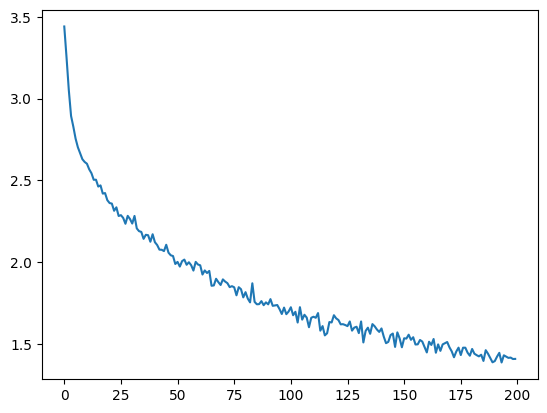

In [247]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [251]:
max_length = 100

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        
        hidden = lstm.initHidden()
        output_name = start_letter
        
        # print(category_tensor.shape)
        # print(input.shape)
        # print(hidden.shape)
        # print(output_name)

        for i in range(max_length):
            output, hidden = lstm(category_tensor, input, hidden)
            #print(output.shape)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [252]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
samples('Simulation')

Armored Core 
Black Staff 
Catceman Battle of the Simulator


LSTM is better -> IF you compare the loss for LSTM and RNN 

